In [23]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [62]:
import os
import sys
sys.path.insert(0,"..")

# Font Size
import matplotlib
font = {'family' : 'DejaVu Sans',
        'weight' : 'bold',
        'size'   : 12}

matplotlib.rc('font', **font)

import torchxrayvision as xrv
import torchvision, torchvision.transforms
from torchxrayvision.datasets import COVID19_Dataset, CovariateDataset

from skimage.transform import resize

from glob import glob
import matplotlib.pyplot as plt
import numpy as np
import torch
import torchvision

# Ratios to plot.
RATIOS = [0.1, 0.3, 0.5, 0.7, 0.9]
COVID_DIR = "../../covid-chestxray-dataset"  # Path to https://github.com/ieee8023/covid-chestxray-dataset
IMG_SIZE = 224
SEED = 1234
PATHOLOGY =  "Viral"

In [63]:
def split_data(data):
    """Splits the images into two arrays, one for each class."""
    X0, X1 = [], []

    for d in data:
        X = d['img']
        y = d['lab']

        if y == 0:
            X0.append(X)
        elif y == 1:
            X1.append(X)

    return X0, X1

# Get the COVID19 Images from Two Views (AP / PA)

In [64]:
transform = torchvision.transforms.Compose(
    [xrv.datasets.XRayCenterCrop(), xrv.datasets.XRayResizer(IMG_SIZE)])

c19_ap = COVID19_Dataset(
    imgpath=os.path.join(COVID_DIR, "images"),
    csvpath=os.path.join(COVID_DIR, "metadata.csv"),
    views=["AP", "AP_Supine"],
    transform=transform)

c19_pa = COVID19_Dataset(
    imgpath=os.path.join(COVID_DIR, "images"),
    csvpath=os.path.join(COVID_DIR, "metadata.csv"),
    views=["PA"],
    transform=transform)

# Collect the Mean Class-Conditional Image for each Ratio

In [65]:
all_diffs, all_X0, all_X1 = [], [], []
vmin = np.inf
vmax = -np.inf

for ratio in RATIOS:
    cvd = CovariateDataset(
        c19_ap,
        c19_ap.labels[:, c19_ap.pathologies.index(PATHOLOGY)],
        c19_pa,
        c19_pa.labels[:, c19_pa.pathologies.index(PATHOLOGY)],
        ratio=ratio, mode='train', seed=SEED)

    X0, X1 = split_data(cvd)
    X0 = np.mean(np.concatenate(X0, axis=0), axis=0)
    X1 = np.mean(np.concatenate(X1, axis=0), axis=0)
    diff = X1 - X0

    all_diffs.append(diff)
    all_X0.append(X0)
    all_X1.append(X1)

    vmin = min(np.min(diff), vmin)
    vmax = max(np.max(diff), vmax)

# Plot all Ratios

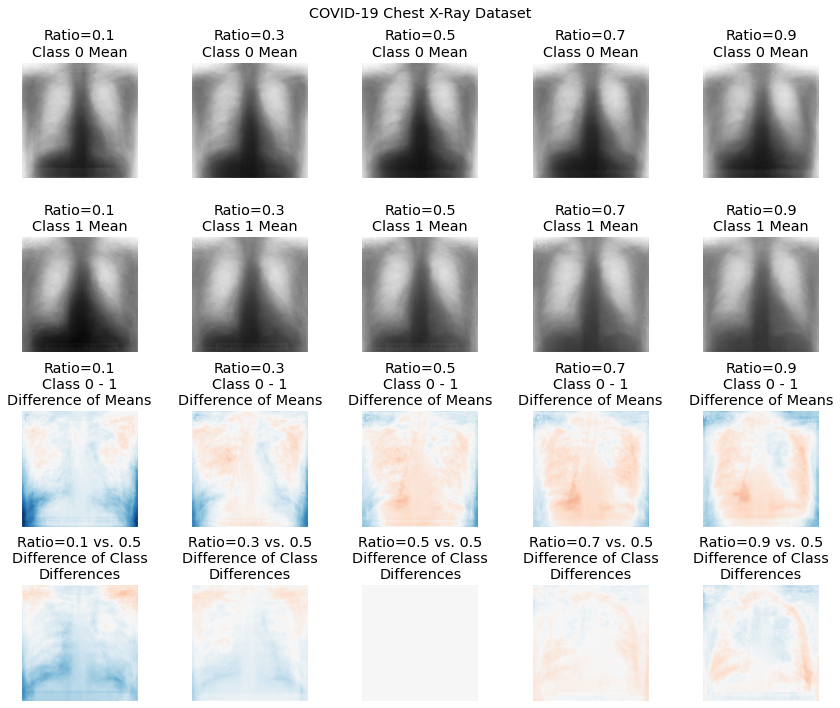

In [69]:
fig, axs = plt.subplots(4, 5, figsize=(12, 10))
#axs = axs.ravel()
vlim = max(np.abs(vmin), np.abs(vmax))

for i, (diff, ratio) in enumerate(zip(all_diffs, RATIOS)):
    
    axs[0][i].imshow(all_X0[i], vmin=-vlim, vmax=vlim, cmap='Greys')
    axs[0][i].set_title("Ratio={}\nClass 0 Mean".format(ratio))
    axs[0][i].axis('off')   
    
    axs[1][i].imshow(all_X1[i], vmin=-vlim, vmax=vlim, cmap='Greys')
    axs[1][i].set_title("Ratio={}\nClass 1 Mean".format(ratio))
    axs[1][i].axis('off') 
    
    axs[2][i].imshow(diff, vmin=-vlim, vmax=vlim, cmap='RdBu')
    axs[2][i].set_title("Ratio={}\nClass 0 - 1\nDifference of Means".format(ratio))
    axs[2][i].axis('off')   
    
    axs[3][i].imshow(diff - all_diffs[2], vmin=-vlim, vmax=vlim, cmap='RdBu')
    axs[3][i].set_title("Ratio={} vs. 0.5\nDifference of Class\nDifferences".format(ratio))
    axs[3][i].axis('off')

fig.suptitle("COVID-19 Chest X-Ray Dataset")
plt.tight_layout(True)